In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../../data/data.csv')
df
'''
Action Items:
    a. Create a model to predict number of free trials generated based on marketing campaign strategy. -
    b. Understand the dataset through EDA -
    c. Explain correlation, patterns, anomalies through visualizations -
    d. Choose an appropriate model -
'''

'\nAction Items:\n    a. Create a model to predict number of free trials generated based on marketing campaign strategy. -\n    b. Understand the dataset through EDA -\n    c. Explain correlation, patterns, anomalies through visualizations -\n    d. Choose an appropriate model -\n'

In [27]:
'''
1. Data Types Breakdown:
    a. REPORT_DATE: Numerical | (Discrete -> Interval -> DateTime object)
    b. ATL_OR_DR: Categorical | (Nominal  -> String)
    c. CAMPAIGN_TYPE: Categorical | (Nominal -> String)
    d. CHANNEL: Categorical | (Nominal -> String)
    e. COST: Quantitative | (Continuous -> Ratio -> Float)
    f. FREE TRAILS: Quantitative | ( Continuous -> Ratio -> Float)

2. Data Questions/Concerns:
    a. Is 'FREE TRAILS' a generated impression count from another model? How does a a free trial
    lead to continous values instead of discrete?

3. Action Items:
    a. Ensure proper data types across dataframe - DONE
    b. Identify missing data gaps - DONE
    c. Decide on encoding strategy for categorical data - DONE
'''
colNames = df.columns
categorical = colNames[1:4].values
quantitative = colNames[4::].values
print(f'Categorical: {categorical}\nQuantitative: {quantitative} \n')
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])
print(f'Table Dimension: {df.shape} \n')
df.info()

Categorical: ['ATL_OR_DR' 'CAMPAIGN_TYPE ' 'CHANNEL']
Quantitative: ['COST' 'FREE TRIALS'] 

Table Dimension: (14108, 6) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14108 entries, 0 to 14107
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   REPORT_DATE     14108 non-null  datetime64[ns]
 1   ATL_OR_DR       14108 non-null  object        
 2   CAMPAIGN_TYPE   14108 non-null  object        
 3   CHANNEL         14108 non-null  object        
 4   COST            14108 non-null  float64       
 5   FREE TRIALS     14108 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 661.4+ KB


### Univariate Analysis on Continuous Data

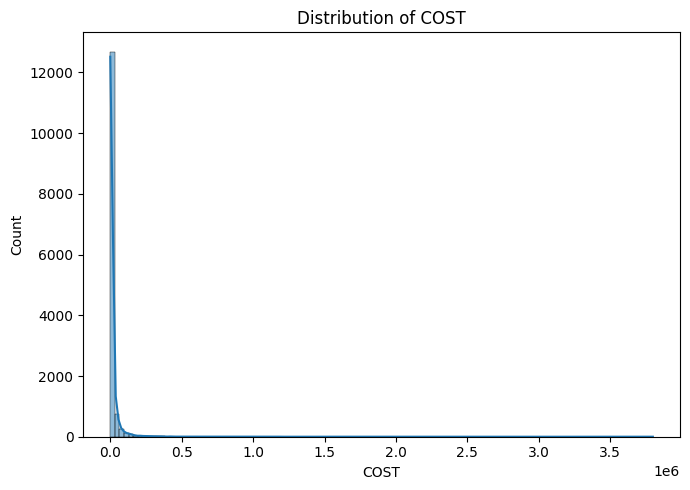

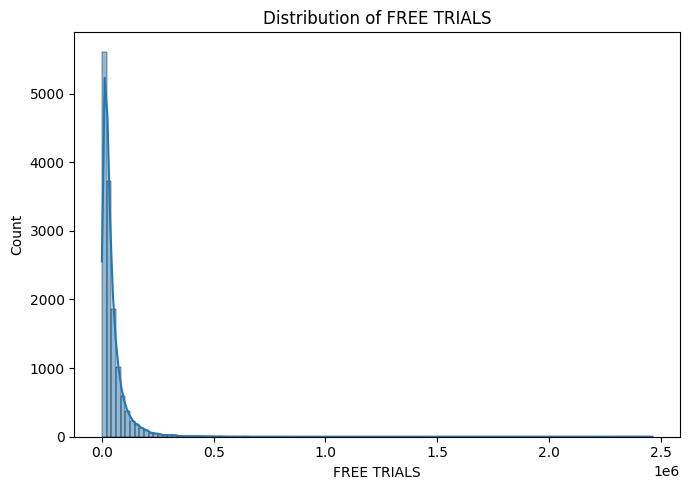

In [28]:
'''
Single Variation Continuous Analysis using Histogram with 118 bins | bin size ~= SqRoot(n):

1. 'COST' Observations/Thoughts/Tasks:
    a. The distriution of 'COST' shows a right skewed distribution with outliers on the right side. So, the mean will
    be greater than the median.
    b. We see lower variance in 'COST' for campaigns under $2,500 and we see a larger variance for cost of campaigns
    as 'COST' increases. This could be the fact that higher costing campaigns has more features/requirements which
    leads to specialized campaign stragetgies whereas lower costing campaigns share similiar requirements/features and
    therefore have lower variance/fixed costs.
    d. Campaigns that cost north of $25,000 are seen as outliers with the highest being 3.75M. Something to explore is
    finding the lag/lead dates of campaigns with high costs and see if there were any significant events/holidays that
    contributed to the spike in cost - (Black Friday, Cyber Monday, New Years, Christmas, Super Bowl, etc). Also, the
    fact that we have so many outliers clustered around the same range makes me challenge the data if these are indeed
    truly outliers.
    e. Most of the cluster of 'COST' is around 0 which is surprising because I wouldn't have guessed the majority of
    campaigns to incur 0 expenses. Is 0 a placeholder for missing data?
    f. Need to better understand the variance of the data via boxplots for further inspections as well as diving deeper
    into the outliers via IQR's.
    g. This dimension violates Linear Regression's assumption of normality. Need to log transform this feature
    to normalize the data and reduce outlier impact

2. 'FREE TRIALS' Observations/Thoughts/Tasks:
    a. The distriution of 'FREE TRIALS' shows a right skewed distribution with outliers on the right side. So, the mean
    will be greater than the median.
    b. 'FREE TRIALS' has a slight larger variance when compared to 'COST'. We see most of campaigns tend generate no
    more than 250,000 'FREE TRIALS ' and with most of them generating minimal 'FREE TRIALS'. Is this a reflection of the
    high barrier of entry for certain campaign strategies or incorrect representation of data. However, we do have some
    campaigns that were very succesful generating over 1M and the highest around 2.5M which causes heavy psotive skew.
    c. Need to look into if there is a linear/non-linear/+/- relationship bewteen 'COST' and 'FREE TRIALS'.My hypothesis
    is that the more you spend on a campaign, the more free trials you generate. Similarly to 'COST', we see a cluster of
    outliers around the certain ranges.
    d. Being able to pull in other data points from other data sources like impression counts could help us put into
    perspective truly how "successful" these free trials are from the total impressions per campaign. A campaign that
    only got 50,000 free trials from a 100,000 impressions is succsesful turnout is better than a campaign that got 100,000
    free trials with 2M impressions.
    d. Need to better understand the variance of the data via boxplots for further inspections as well as diving deeper
    into the outliers via IQR's.
    e. This dimension violates Linear Regression's assumption of normality. Need to log transform this feature to
    normalize the data and reduce outlier impact

3. Action Items:
    a. Log Transformation on 'COST' and 'FREE TRIALS'. - DONE
    b. Single Variation Continuous Analysis using boxplots - DONE
    c. Covaritation Continuous Analysis between 'COST' and 'FREE TRIALS' using a scatterplot. - DONE
'''
for quant_col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.histplot(df[quant_col], kde=True, bins=118)
    plt.title(f'Distribution of {quant_col}')
    plt.tight_layout()
    plt.show()

In [29]:
'''
Descriptive Analysis:
1. 'COST' Observations/Thoughts/Tasks:
    a. Such a high standard deviation (the weight of outliers), which accounts for units unlike variance, validates
    the spread from the visuals and the extereme outliers that are inflating these stats.
    b. 0-25% of the cost ranged from $0-$945.
    c. 25-50% of the cost ranged from $945-$3,164.
    d. 50-75% of the cost ranged from $3,164-$10,641.
    e. 75-100% of the cost ranged from $10,641-$3.7M.
    f. Using median over average due to skewness: $3,164 tends to be the cost of your typical campaign
    g. Cannot infer too much with statistics due to exterme outliers.

2. 'FREE TRIALS' Observations/Thoughts/Tasks:
    a. Such a high standard deviation (the weight of outliers), which accounts for units unlike variance, validates
    the spread from the visuals and the extereme outliers that are inflating these stats.The fact that this is
    high varaince is a good sign that this is a feature is a good target variable.
    b. The lowest free trial was at 576. If the lowest generated campaign was 576, perhaps we can assume that data
    where 'COST' shows 0 is a replacement of missing data?
    c. 0-25% of the free trials ranged from 576-13,935.
    d. 25-50% of the free trials ranged from 13,935-27,776.
    e. 50-75% of the free trials ranged from 27,776-54,678.
    f. 75-100% of the free trials ranged from 54,678-2.4M.
    g. Using median over average due to skewness: 27,777 trials tend to be your typical campaign
    h. Cannot infer too much with statistics due to exterme outliers.

3. Action Items:
    a. Feature engineer a KPI metric on campaign efficency: 'COST'/'FREE TRAILS' and perform visualizations
    b. Feature engineer a boolean lag/lead flag feature for holiday events and a categorical seasons dimension
    using datetime library. This can answer outlier questions and help us understand the data better.
    c. Visualize and aggregate 'FREE TRIALS' by channel types across year to see if certain channel types are becoming
    more or less popular/lucrative over time. This can help tailor our marketing strategies to the most effective
    channels.
    d. Create Boxplot for 'COST' and 'FREE TRAILS' to better understand the variance of the data. - DONE
'''
df[quantitative].describe()

,COST,FREE TRIALS
count,1.410800e+04,1.410800e+04
mean,1.655741e+04,4.545834e+04
std,7.359892e+04,6.040529e+04
min,0.000000e+00,5.762400e+02
25%,9.457675e+02,1.393528e+04
50%,3.164070e+03,2.777694e+04
75%,1.064149e+04,5.467904e+04
max,3.798940e+06,2.463082e+06


C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\143712426.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, palette='Set2')


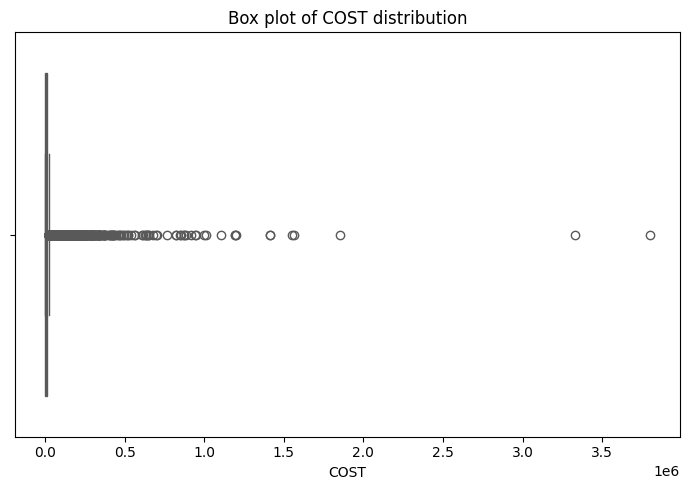

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\143712426.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, palette='Set2')


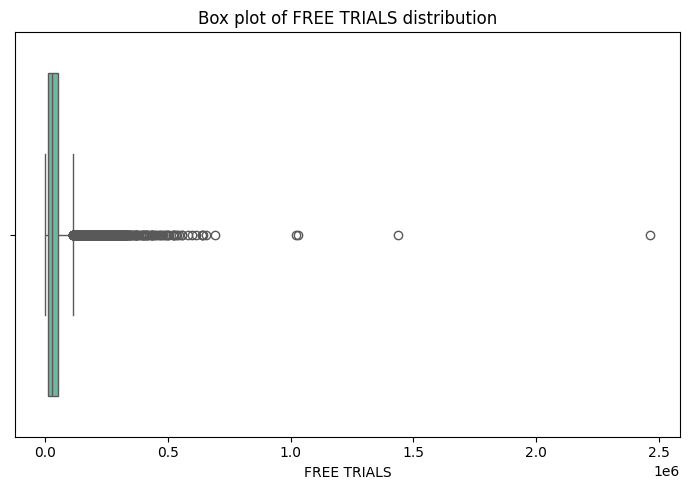

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\143712426.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, showfliers=False, palette='Set2')


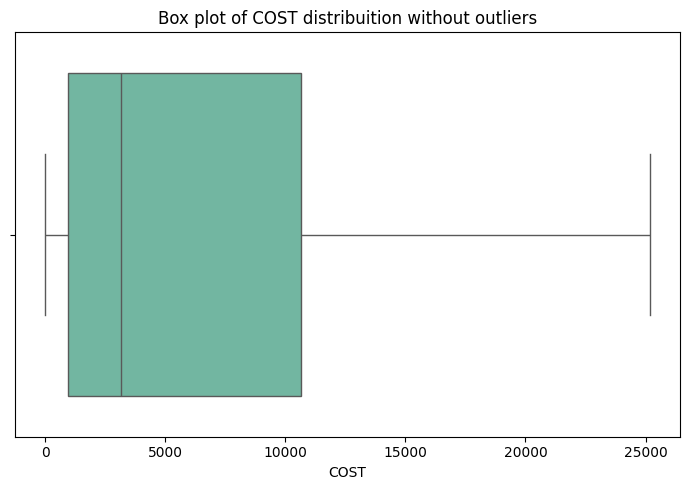

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\143712426.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, data=df, showfliers=False, palette='Set2')


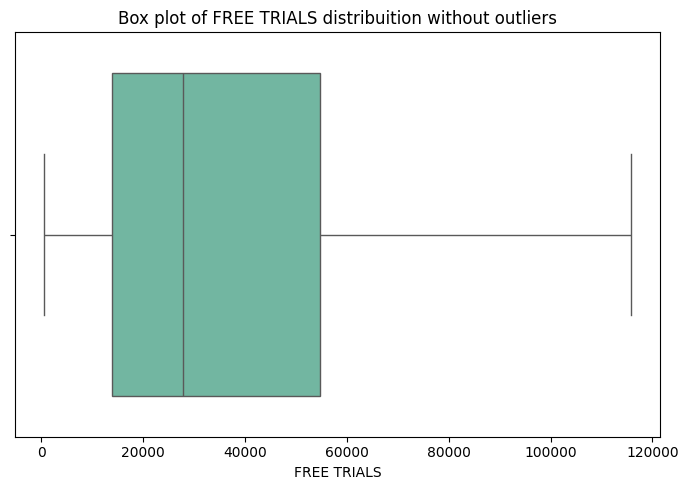

In [30]:
'''
Single Variation Continuous Analysis using BoxPlots:

1. 'COST' + 'FREE TRIALS'  Observations/Thoughts/Tasks:
    a. Very low variance in the data custered the 0-50th percentile. Whereas once 'COST'/'FREE TRIALS' passes the
    50th percentile we see variance increase.
    b. We see large clusters of "outlier" data around the upper whisker. The high frequency of these data points
    leads me to think these aren't your typical outliers to throw out and further stregnthens the need to transform the
    data to addrewss the skenwss in our data.
    c. Ultimately, hesitant to get rid of extereme outliers. Need to understand the reason behind these inflated 'COST'/'FREE TRIAL'
    because they align with our business objective of generating high free trials and understanding how we can replicate
    these successful campaigns as well as reducing costs for campaigns.

2. Action Items:
    a. Look into other metadata to see are there any relationships between the 0-25% range of 'COST' and 'FREE TRIALS'
    type campaigns and the 75-100% range via filtering.
'''
for col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=col, data=df, palette='Set2')
    plt.title(f'Box plot of {col} distribution')
    plt.tight_layout()
    plt.show()

for col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=col, data=df, showfliers=False, palette='Set2')
    plt.title(f'Box plot of {col} distribuition without outliers')
    plt.tight_layout()
    plt.show()

In [31]:
df[df['FREE TRIALS'] <= df['FREE TRIALS'].quantile(0.50)].sort_values('FREE TRIALS', ascending=False) #14,108

,REPORT_DATE,ATL_OR_DR,CAMPAIGN_TYPE,CHANNEL,COST,FREE TRIALS
9930,2023-06-01,ATL - Above The Line,Title,bvod,888.71,27775.90
6116,2022-09-11,ATL - Above The Line,Title,cinema,14011.68,27775.16
8692,2022-08-21,ATL - Above The Line,Brand,youtube,8271.85,27775.01
11692,2024-03-23,ATL - Above The Line,Title,tv,46246.47,27769.03
2240,2023-09-19,ATL - Above The Line,Title,youtube,3844.61,27767.25
...,...,...,...,...,...,...
4106,2023-06-12,ATL - Above The Line,Title,bvod,1867.15,971.22
10503,2023-08-24,ATL - Above The Line,Title,cinema,3634.02,827.94
1054,2022-09-16,ATL - Above The Line,Title,cinema,1176.11,719.36
8386,2023-11-13,ATL - Above The Line,Title,youtube,60216.79,705.15


In [32]:
np.exp(8)-1

2979.9579870417283

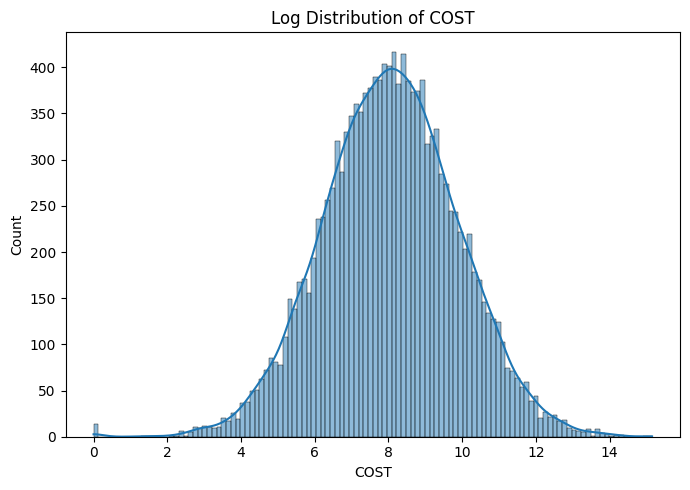

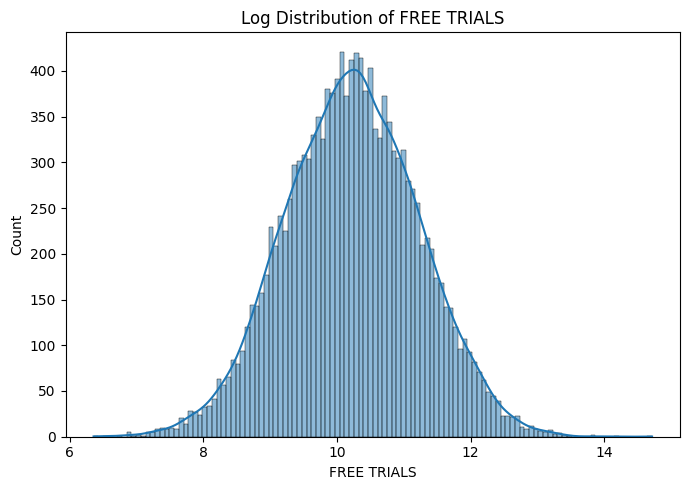

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\2373286140.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[f'{col}_log'], data=df, palette='Set2')


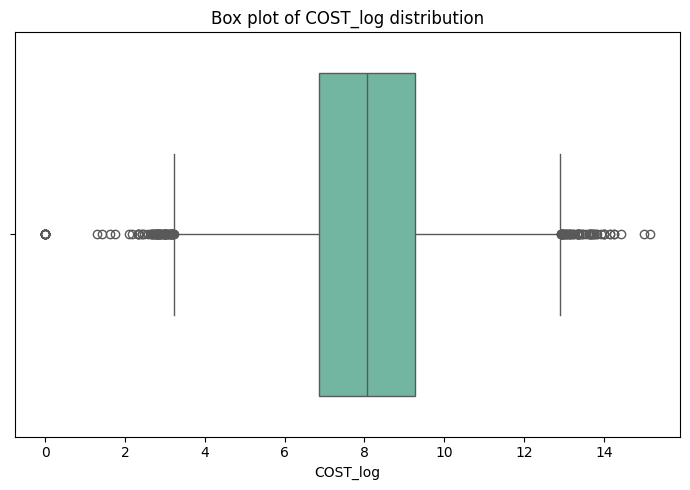

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\2373286140.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[f'{col}_log'], data=df, palette='Set2')


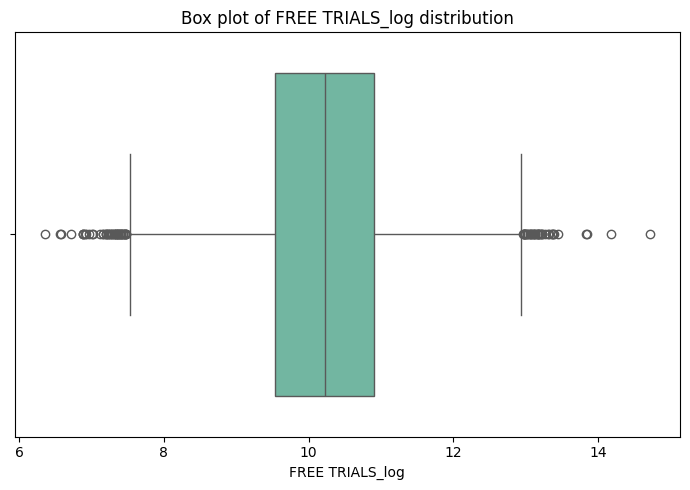

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\2373286140.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[f'{col}_log'], data=df, showfliers=False, palette='Set2')


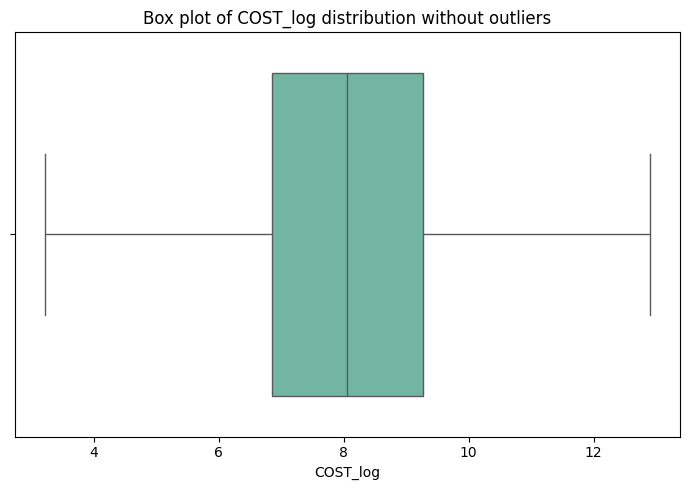

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\2373286140.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[f'{col}_log'], data=df, showfliers=False, palette='Set2')


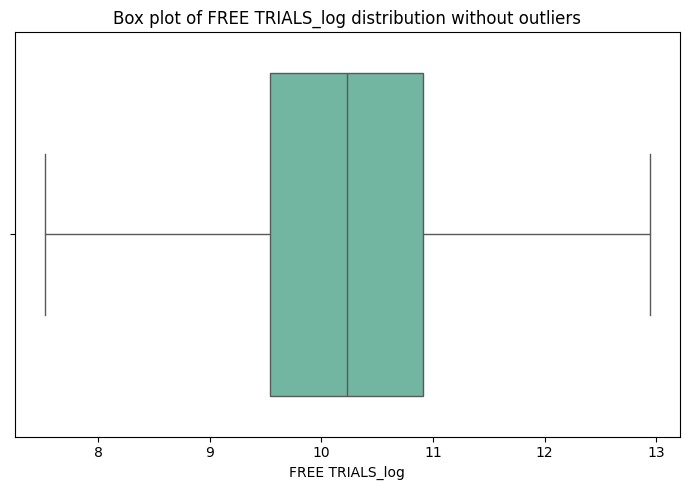

,COST_log,FREE TRIALS_log
count,14108.000000,14108.000000
mean,8.057799,10.228010
std,1.822654,0.998582
min,0.000000,6.358258
25%,6.853054,9.542251
50%,8.059930,10.231998
75%,9.272610,10.909254
max,15.150233,14.716925


In [33]:
'''
Single Variation Log Analysis using Histogram/BoxPlots:

1. 'LOG_COST' Observations/Thoughts/Tasks:
    a. Log transformation is a suitible technique to ensure our data is normally distributed, which longer violates
    linear regression assumptions. We still see a subset of data with 0 cost which further gives concerns regarding
    the context of '0' and if it's being misreperesented.
    b. 'COST' median/mean: $3,000 -> normally distribution | 25%: $950 | 75%: $10,600
    c. The spread of outliers are symmetrical on both tails. Left tail might not offer much savings opportunities
    but the right tail might provide opportunities to reduce expenses or look into a more cost savings campaign strategy.
    d. Variance is consistent, but we see higher variance in outliers for 'COST' than in the outliers for 'FREE TRIALS'.

2.  'LOG_FREE TRIALS' Observations/Thoughts/Tasks:
    a. Log transformation is a suitible technique to ensure our data is normally distributed, which longer violates
    linear regression assumptions.
    b. 'FREE TRIALS' median/mean: 22,000 -> normally distribution | 25%: 13,903 | 75%: 54,000
    c. We have outliers happening at both tails of the data and with farily frequent occurrence and low variance hence
    signaling a possible driving force behind these cluster of datapoints. We also have a few extereme outliers on both
    tails. Both tails repesent oppportunties: left tail to understand why these campaigns are not generating free trials
    or if there are any data misrepresentation. Right tail to understand how we can replicate these successful campaigns.
    d. Variance is smaller from 0-25% range; but drastically increases more free trials.

3. Action Items:
    a. Using the quartiles to segment and slice the 'LOG_COST' and 'LOG_FREE TRIALS' for further analysis.
    b. Inspect outliers and extreme outliers from log transformation  and slice the data to see if they are
    truly outliers. For extreme outliers in 'FREE TRIALS', filter data on them and see cost value and general
    metadata to see if any patterns emerge. Vise Versa.
    c. Create Covariation Analysis with 'LOG_COST' and 'LOG_FREE TRIALS' using a scatterplot. - DONE
'''
for quant_col in quantitative:
    plt.figure(figsize=(7, 5))
    log_transformed = np.log1p(df[quant_col])
    df[f'{quant_col}_log'] = log_transformed
    sns.histplot(log_transformed, kde=True, bins=118)
    plt.title(f'Log Distribution of {quant_col}')
    plt.tight_layout()
    plt.show()

for col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=df[f'{col}_log'], data=df, palette='Set2')
    plt.title(f'Box plot of {col}_log distribution')
    plt.tight_layout()
    plt.show()

for col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=df[f'{col}_log'], data=df, showfliers=False, palette='Set2')
    plt.title(f'Box plot of {col}_log distribution without outliers')
    plt.tight_layout()
    plt.show()

df[['COST_log','FREE TRIALS_log']].describe()

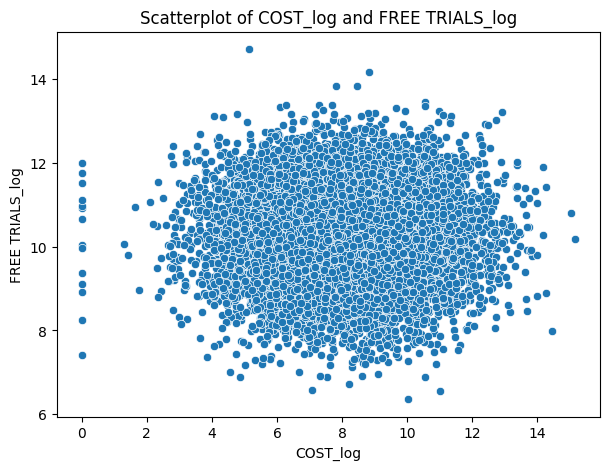

In [34]:
'''
Covariation Analysis using Scatterplot:

1. 'LOG_COST' + 'LOG_FREE TRIALS' Observations/Thoughts/Tasks:
    a. Positive, weak, linear relationship. A higher spending on a campaign doesn't necessarily mean more free trials
    being generated.
    b. The expenses of multiple campaigns with similar costs can still generate a wide range of free trials. This makes
    sense. Some products/brands/titles/services can have higher barriers of entry to get customers to try out their
    product/service compared to others. Some sectors can also be more competitive than others. Also, we don't know what
    the impression count is for these campaigns.
    c. Reinforcing the idea of inspecting 0 'LOG_COST' subset and the likelihood of misrepresentation in the data since
    how can a campaign cost free and also generate more than the average 'LOG_FREE TRIALS'?
    d. We see a high density of data bwetween 'LOG_COST' 4-12 and 8-12 'LOG_FREE TRIALS'. We see that there is quite a
    bit of spread within this sector which tells us there could be multiple factors/relationships that go beyond just
    LOG_COST' and the number of generated 'LOG_FREE TRIALS'.
    e. What makes certain campaigns more successful over others since cost doesn't seem to be a strong indicator.
    f. Edgecases appear around all corners of the central cluster of data points. These subset show weak, linear
    relationship. IE: We have high 'LOG_COST' with low 'LOG_FREE TRIALS'. This can be areas of opportunty for improvement
    in campaign strategy. Also, edge cases where we have low 'LOG_COST' and high 'LOG_FREE TRIALS' near the upper left
    quadrant. trials for repeatiability.

2. Action Items:
    a. Add cateogircal data to the scatterplot to see if there are any relationships between the two.
    b. Filter data on 0's in 'LOG_COST' for more analysis.
    c. Filter data on high 'LOG_COST' with low 'LOG_FREE TRIALS' for more analysis.
    d. Filter data on low 'LOG_COST' and high 'LOG_FREE TRIALS' for more analysis.
'''
plt.figure(figsize=(7, 5))
sns.scatterplot(x='COST_log', y='FREE TRIALS_log', data=df)
plt.title('Scatterplot of COST_log and FREE TRIALS_log')
plt.show()


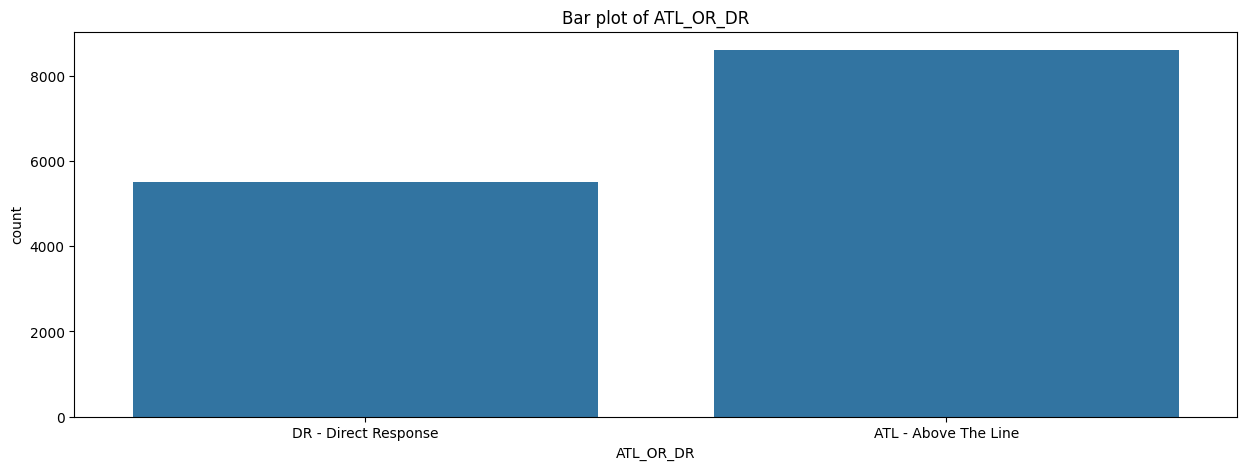

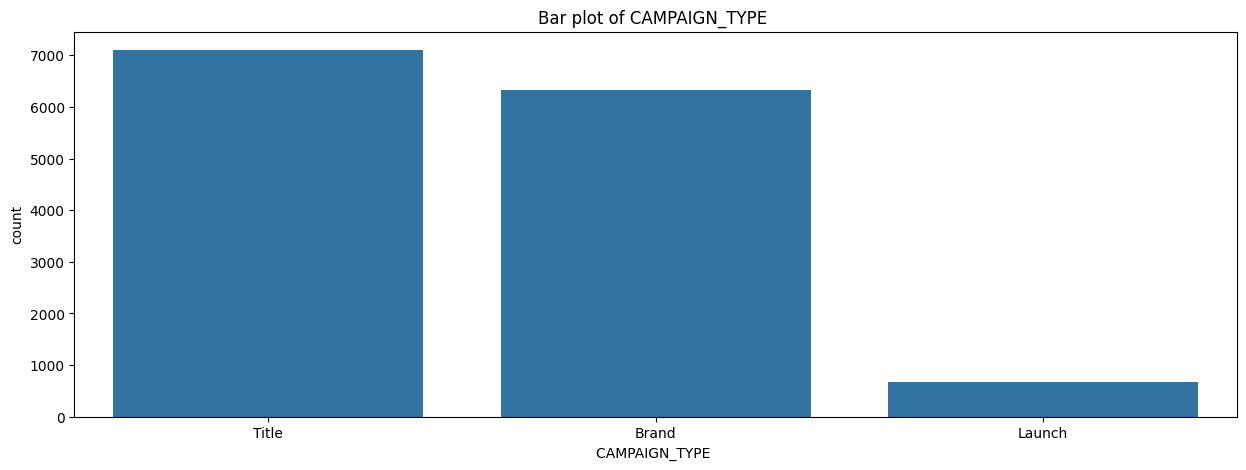

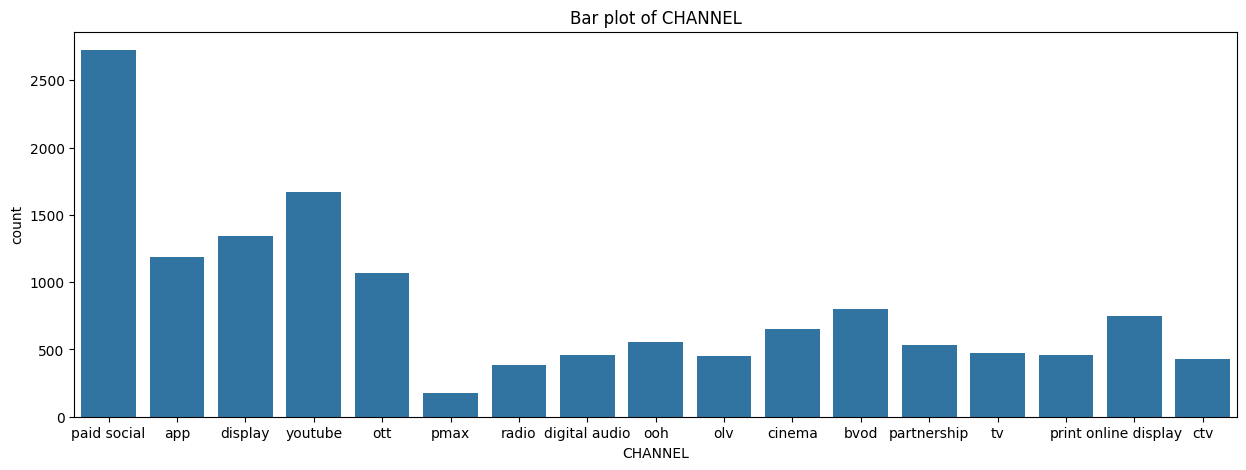

In [35]:
'''
Single Variation Categorical Analysis using Barchart:

1. 'ATL_OR_DR' Observations/Thoughts/Tasks:
    a. Most campaigns are ATL than DR. This aligns with your typical business case of consistently building and
    reinforcing your brand compared to direct response, which is tailored to specific usecases.
    b. I would assume DR generates a lot of free trials since it is immediate and digital, but might not be as affective
    in regards to customer retention. (More data would be needed) However, while sometimes ineffective, it's cheaper.
    This could be a useful strategy and/or pilot to test out certain markets/customer segments behaviors.
    c. I would assume ATL has a higher cost variance than DR since ATL heavily depends on targeting a broader reach and
    having a longer airtime since you are consistenly trying to build and reienforce your brand. But these can vary from
    media types/devices hence the high variance. Special holidays/events can also drive up costs. Free trials tend to be
    smaller but you will have outliers like special events/holidays.

2. 'CAMPAIGN_TYPE' Observations/Thoughts/Tasks:
    a. There are no Promotional Campaigns.
    b. Brand and Title campaigns dominate, while Launch campaigns are infrequent. This aligns with typical product
    lifecycle, where certaint market/regions can have saturiation and therefore have higher barriers of entry leading to
    infrequent new launches/relaunches while companies continue to build and reinforce their brand.
    c. I would assume Brand/Title campaigns may have higher costs than Launch since Brand/Title has to reach a larger
    audience and reach. Brand/Title is more associated with ATL and Launch is more assoicated with DR.

3. 'CHANNEL' Observations/Thoughts/Tasks:
    a. Social and YouTube, which makes sense in the iOT world, drive the makeup of channel for where campaigns get aired.
    Meanwhile, Tv, radio,and print are on the lower tier which illustrastes the shift in digital age. Seeing the cost
    associated to 'CHANNEL' types would help us understand the trade-offs of reallocating resources and areas of
    opportunity.
    b. While Social and YouTube dominate, simply reallocating resources from low-performing channels (e.g., Radio)
    to top channels may not be ideal. Customer segments from different channels could vary significantly and can lose out
    on niche segments. Cost Benefit Analysis would be needed to understand the trade-offs of reallocating resources.

4. Action Items:
    a. Covariation Analysis between Categorical & Continuous' using Scatterplot and hue
    b. Covariation Analysis between categorical and continuous using boxplot and barcharts
'''
for cat in categorical:
    plt.figure(figsize=(15, 5))
    sns.countplot(x=cat, data=df)
    plt.title(f'Bar plot of {cat}')
    plt.show()

### Multivariate Analysis

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\878839886.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_col, y=y_col, hue=hue_col, palette="Set2")


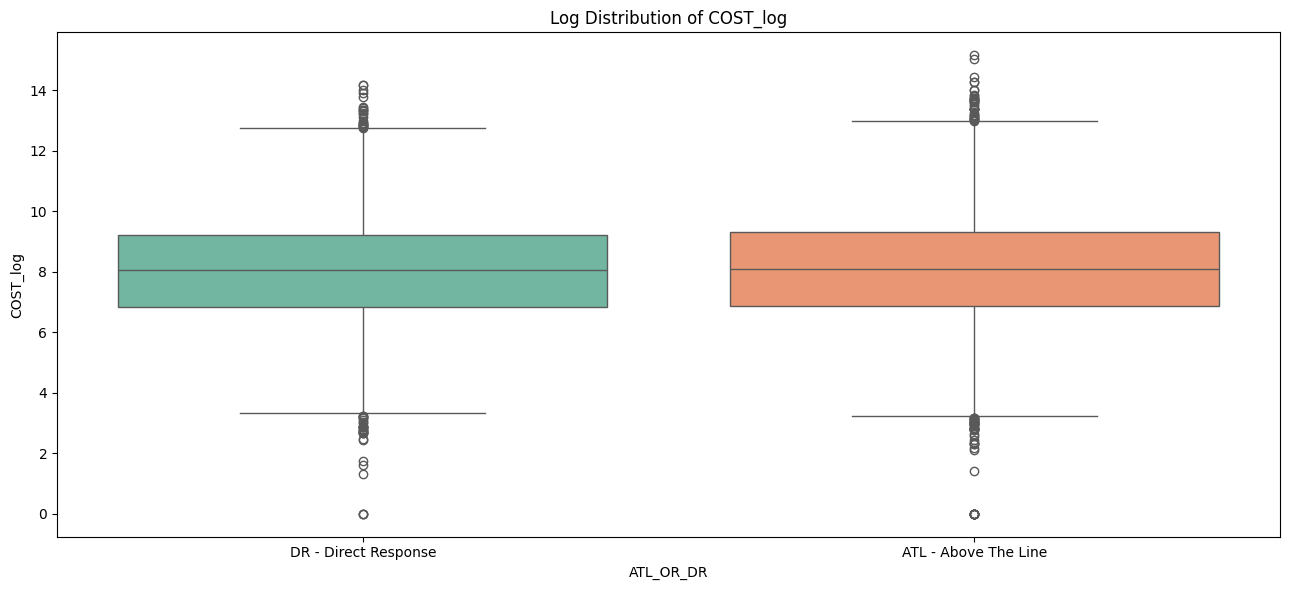

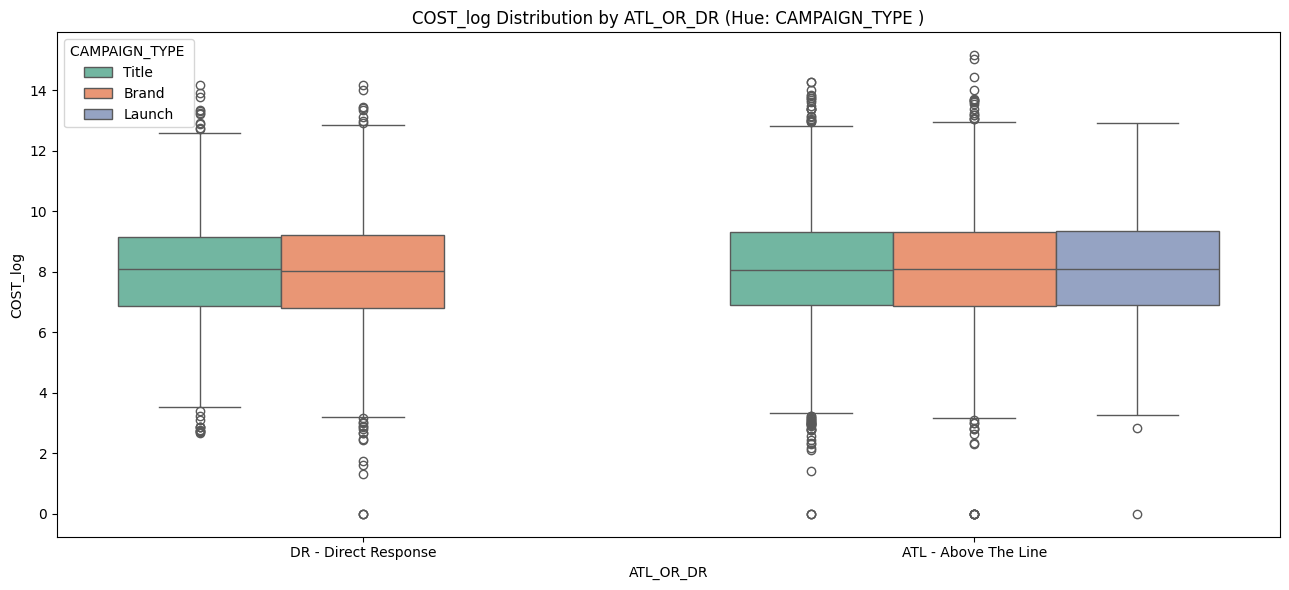

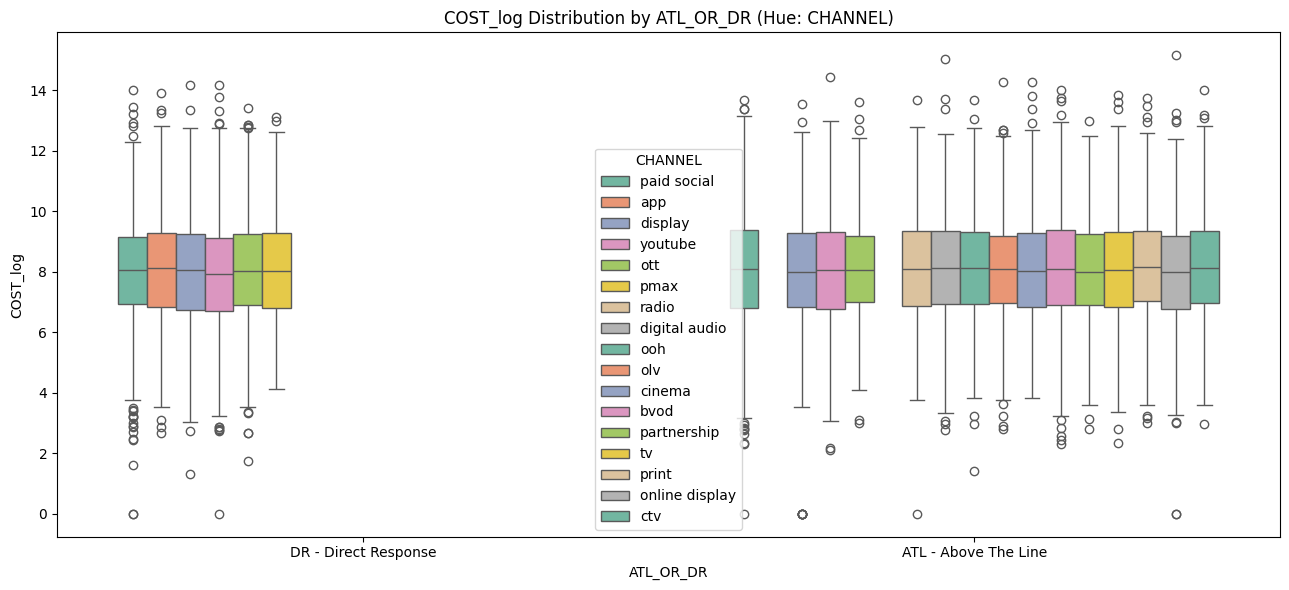

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\878839886.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_col, y=y_col, hue=hue_col, palette="Set2")


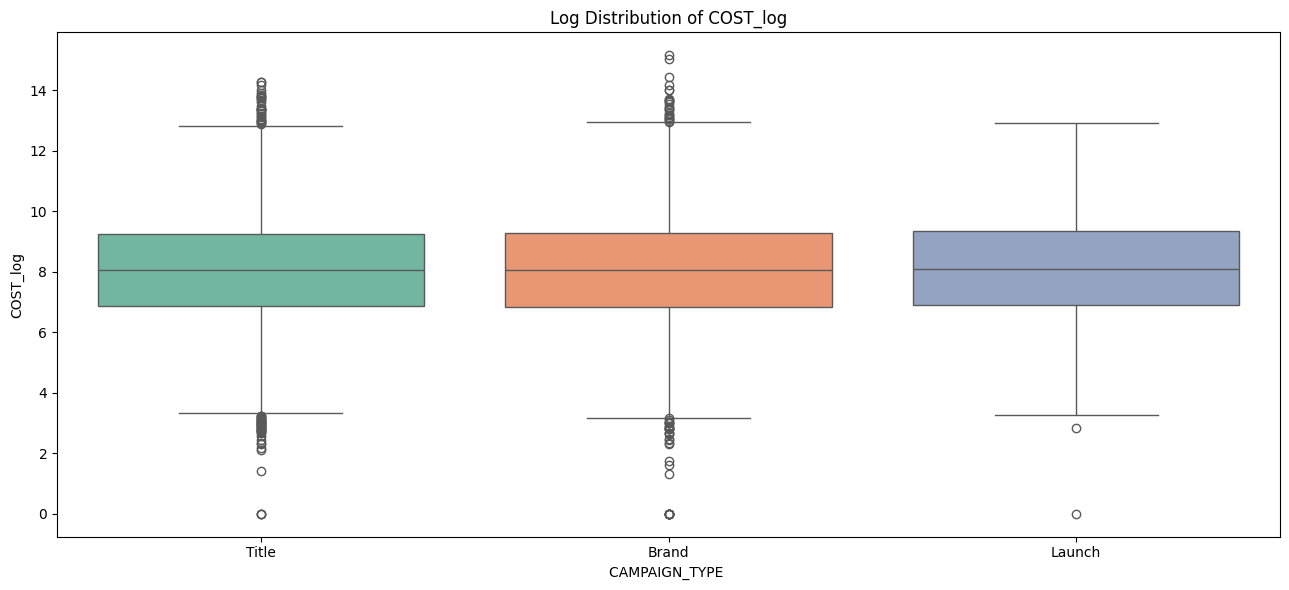

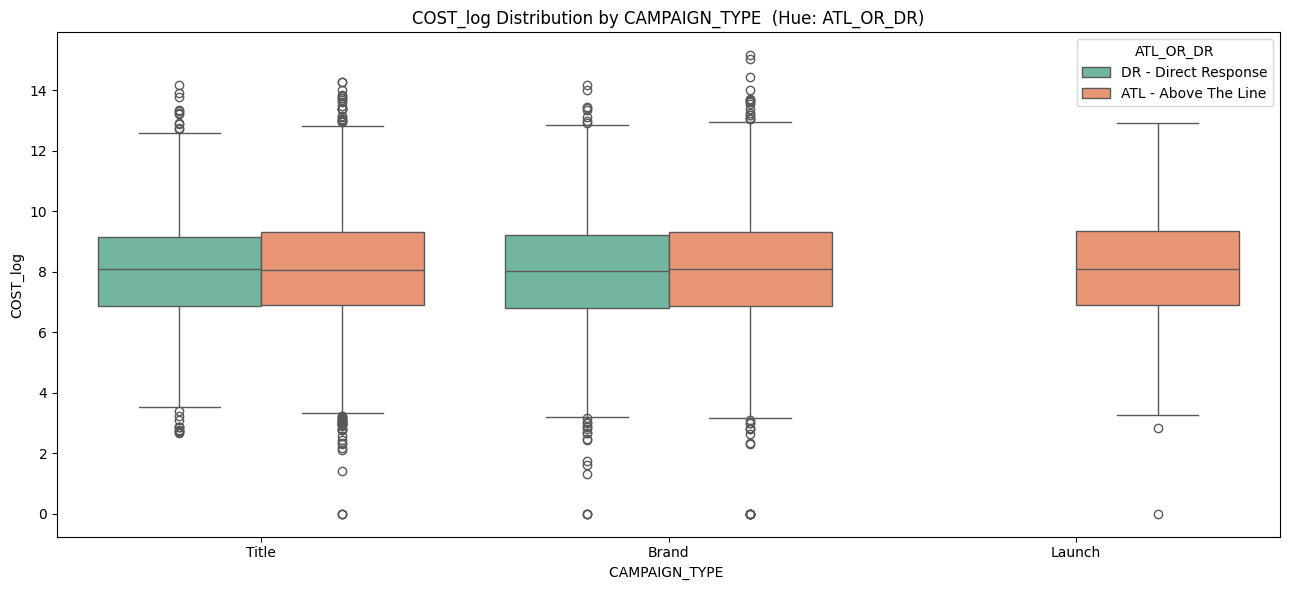

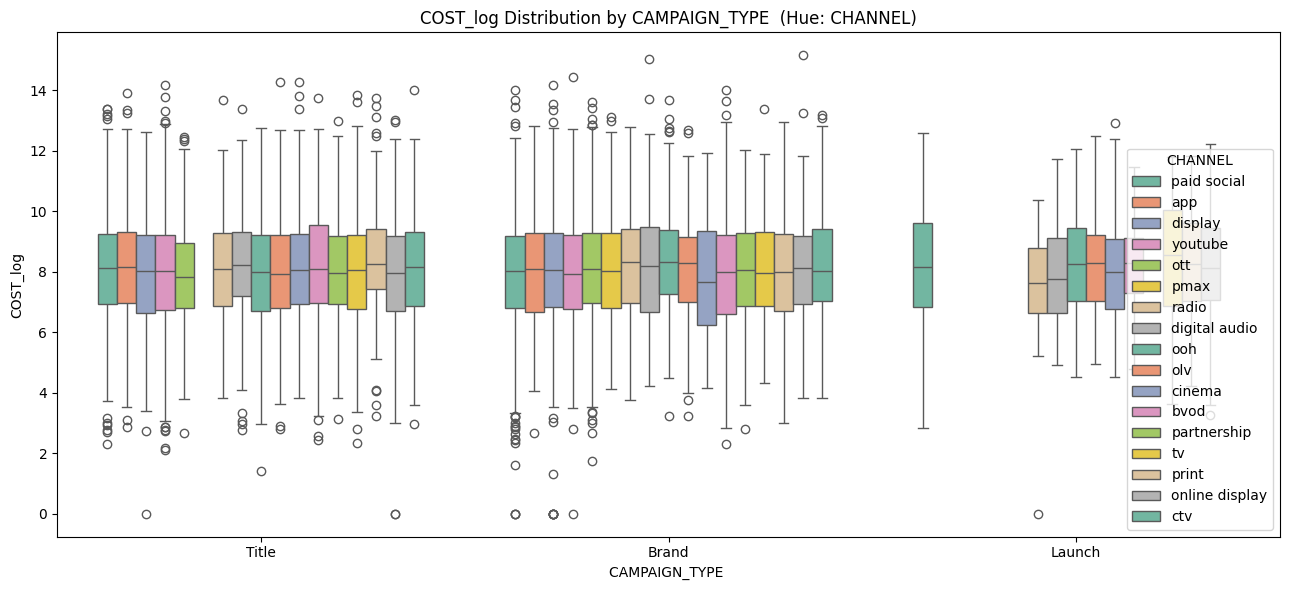

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\878839886.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_col, y=y_col, hue=hue_col, palette="Set2")


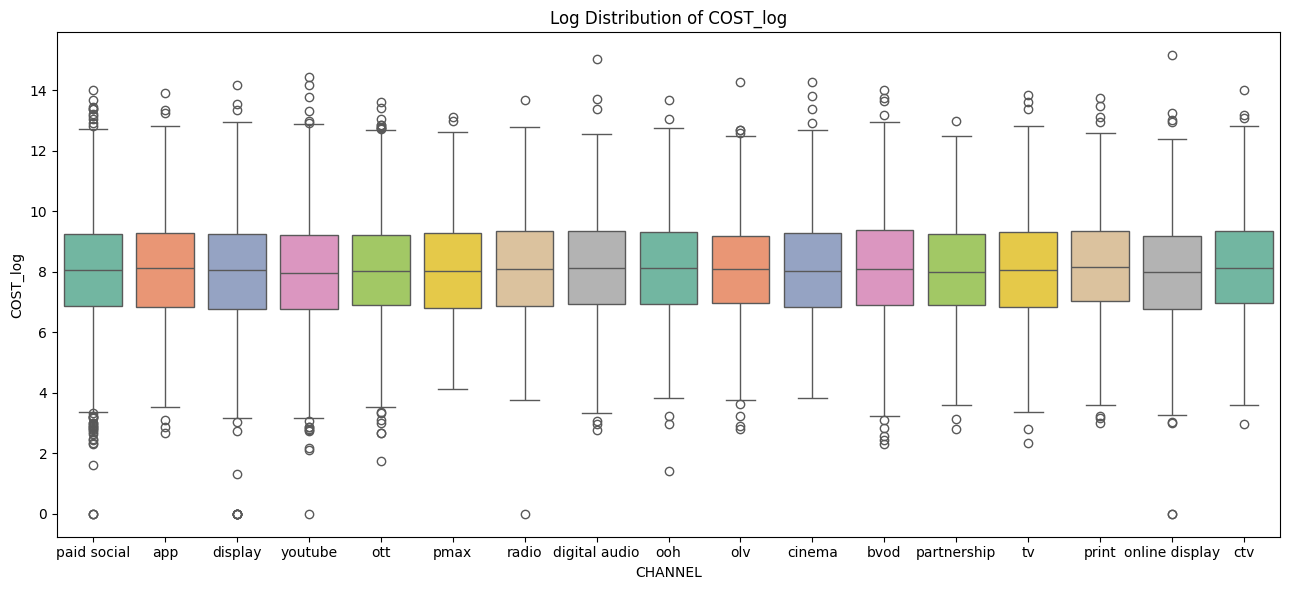

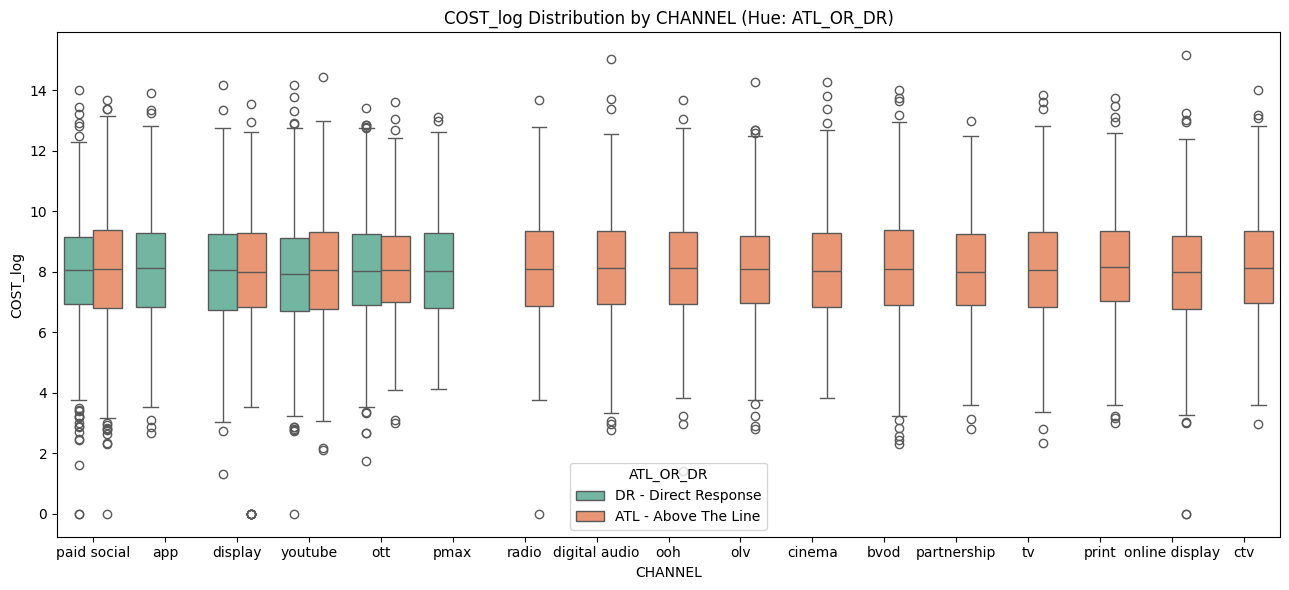

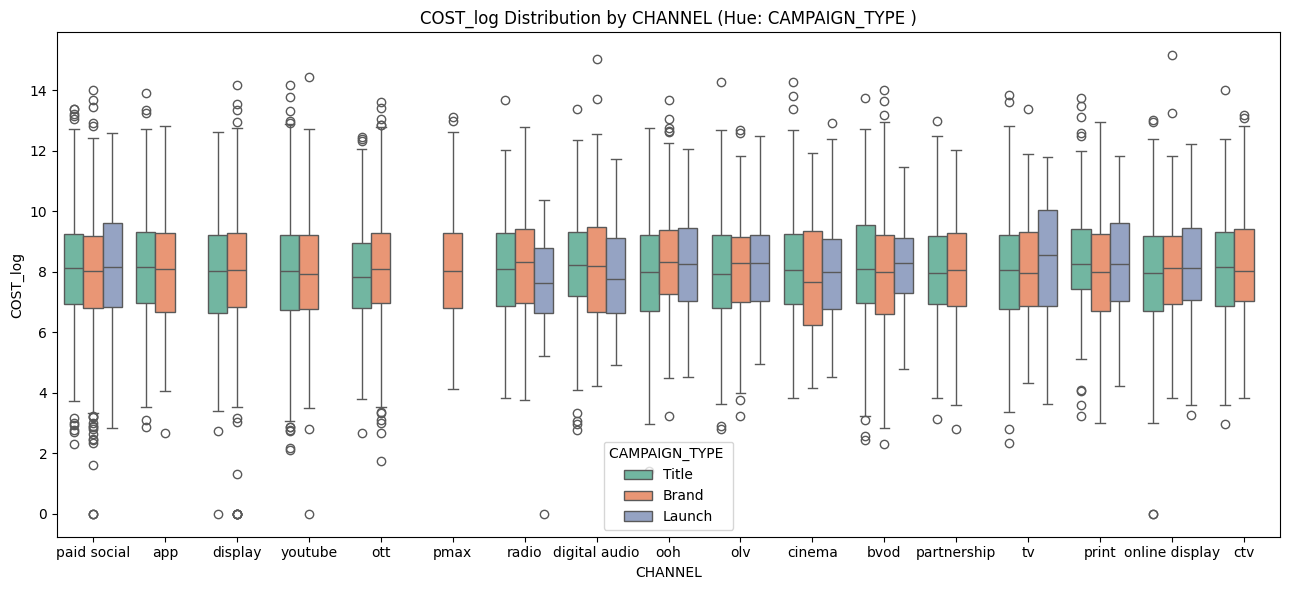

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\878839886.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_col, y=y_col, hue=hue_col, palette="Set2")


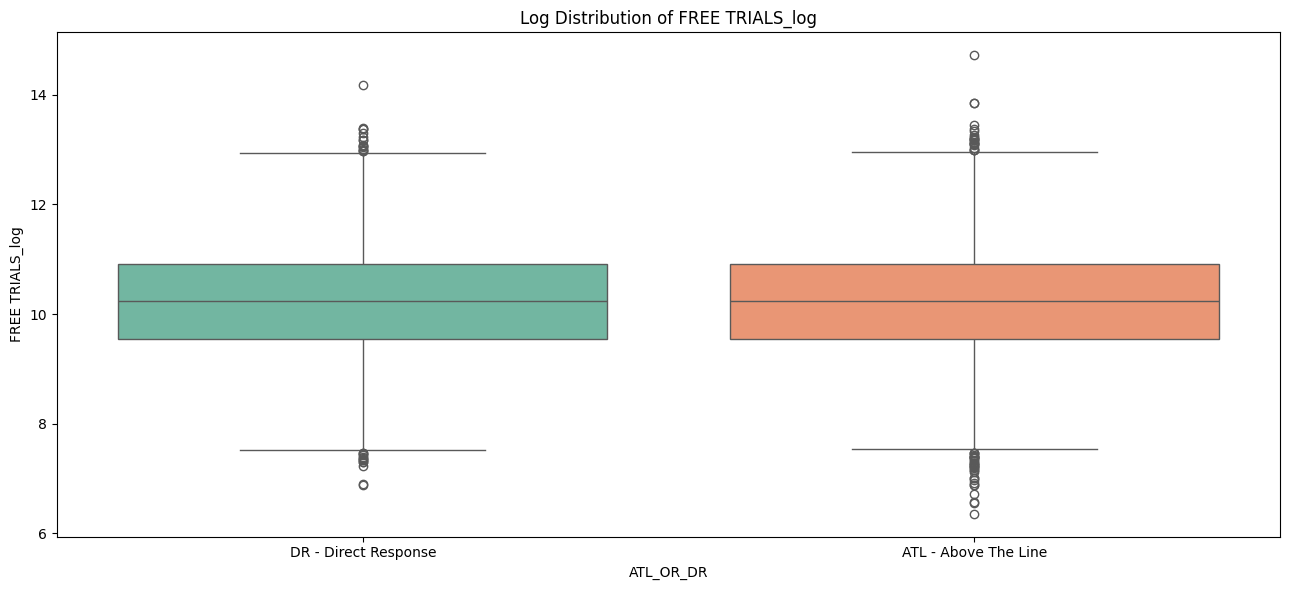

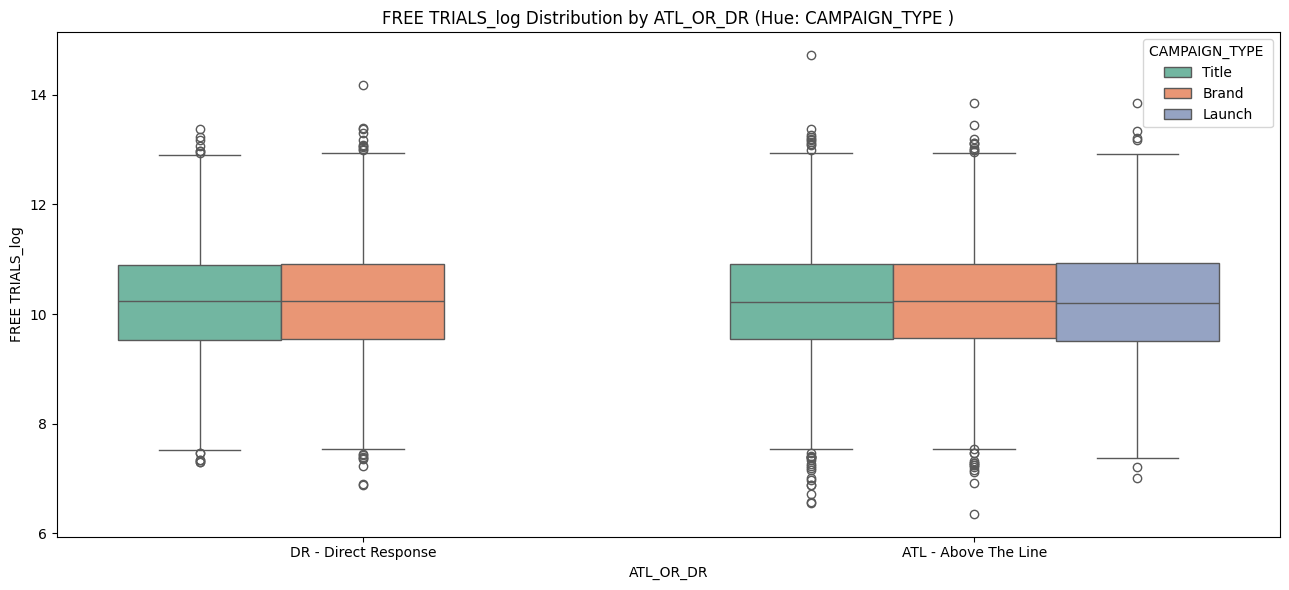

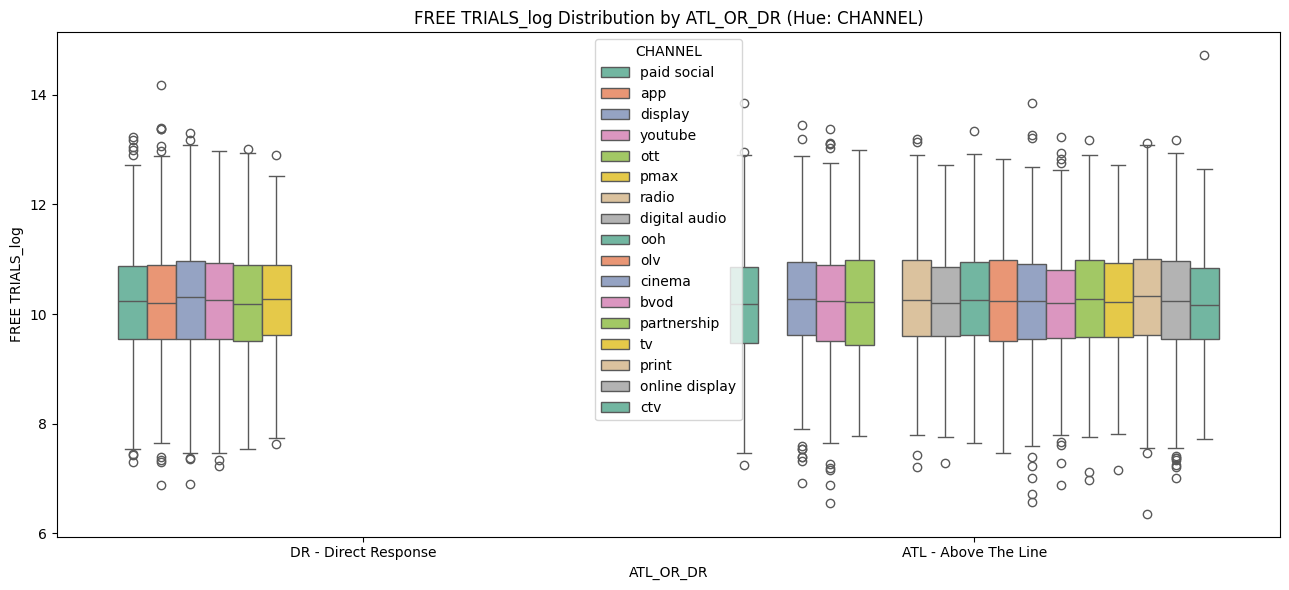

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\878839886.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_col, y=y_col, hue=hue_col, palette="Set2")


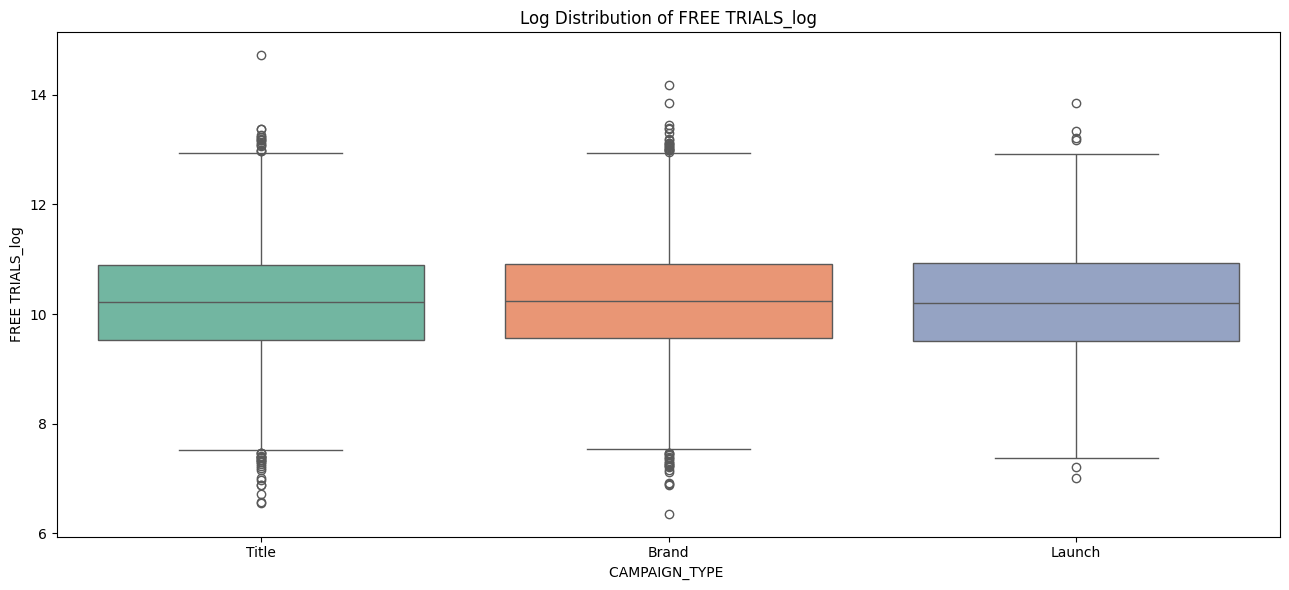

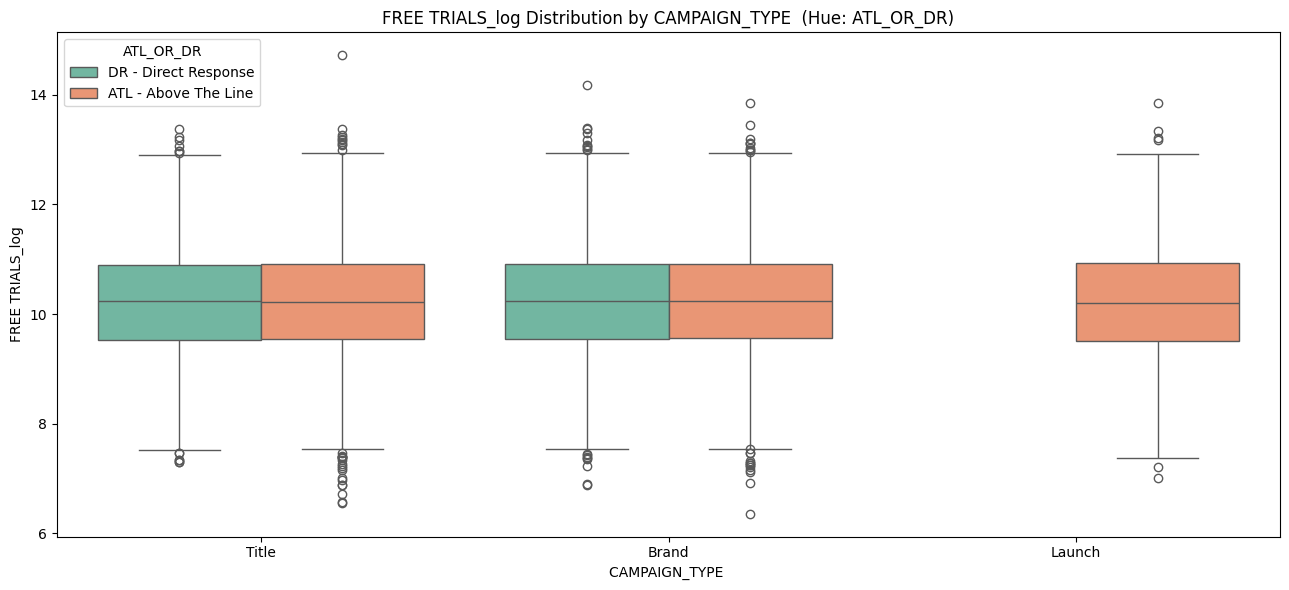

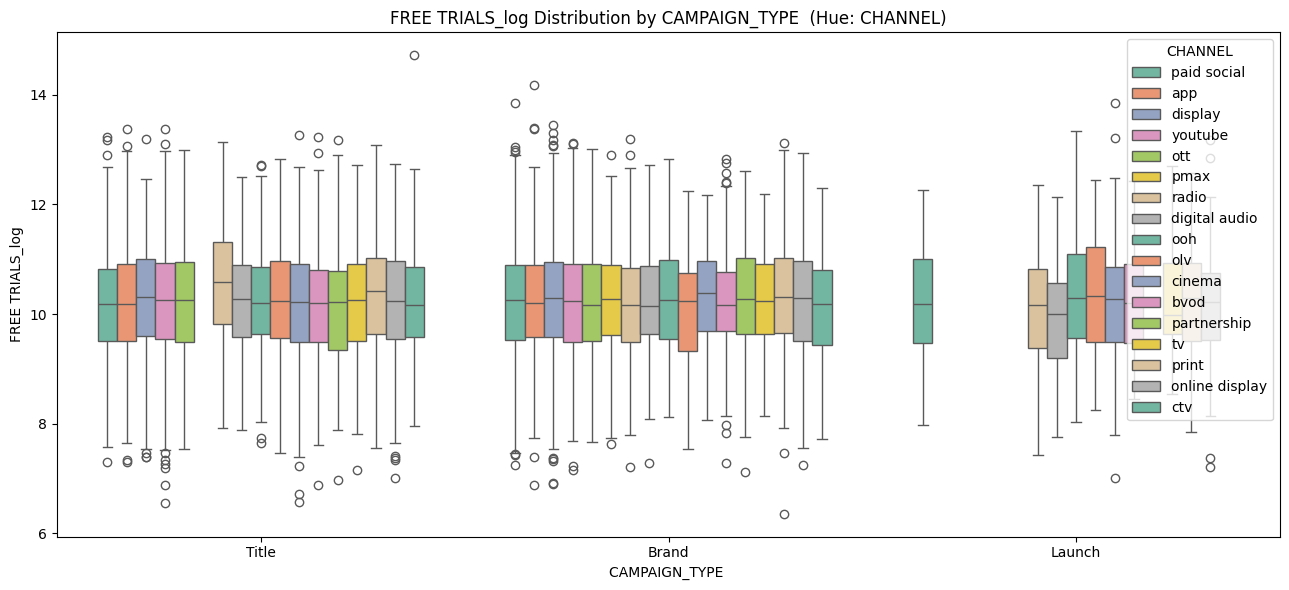

C:\Users\cheng\AppData\Local\Temp\ipykernel_10772\878839886.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_col, y=y_col, hue=hue_col, palette="Set2")


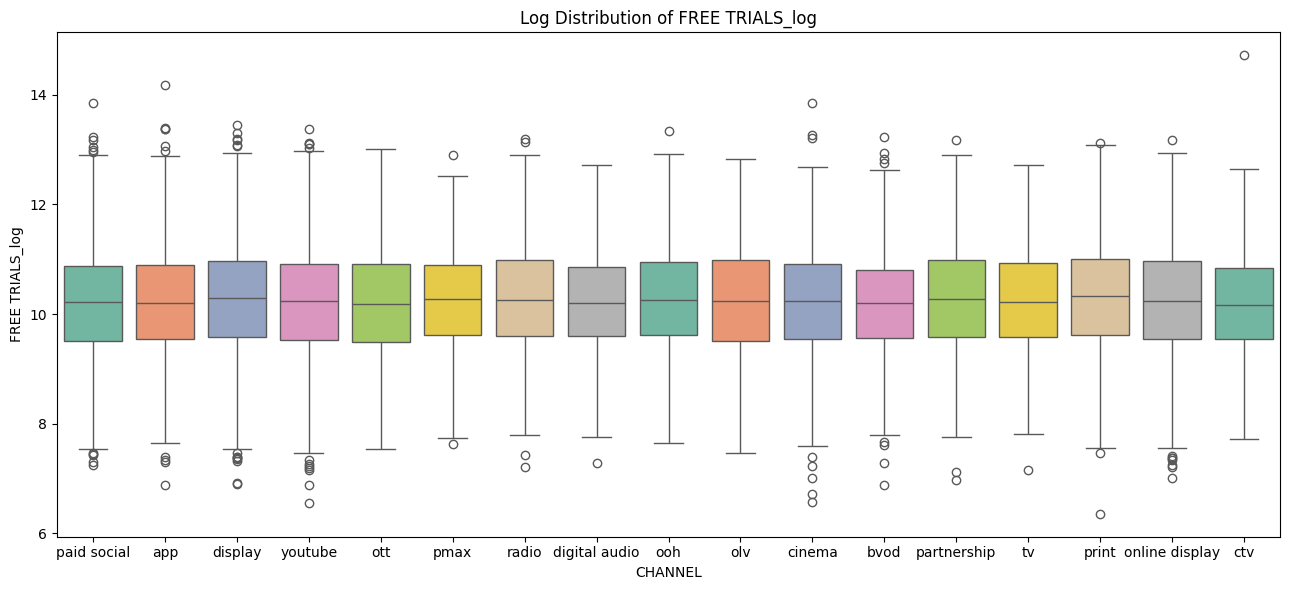

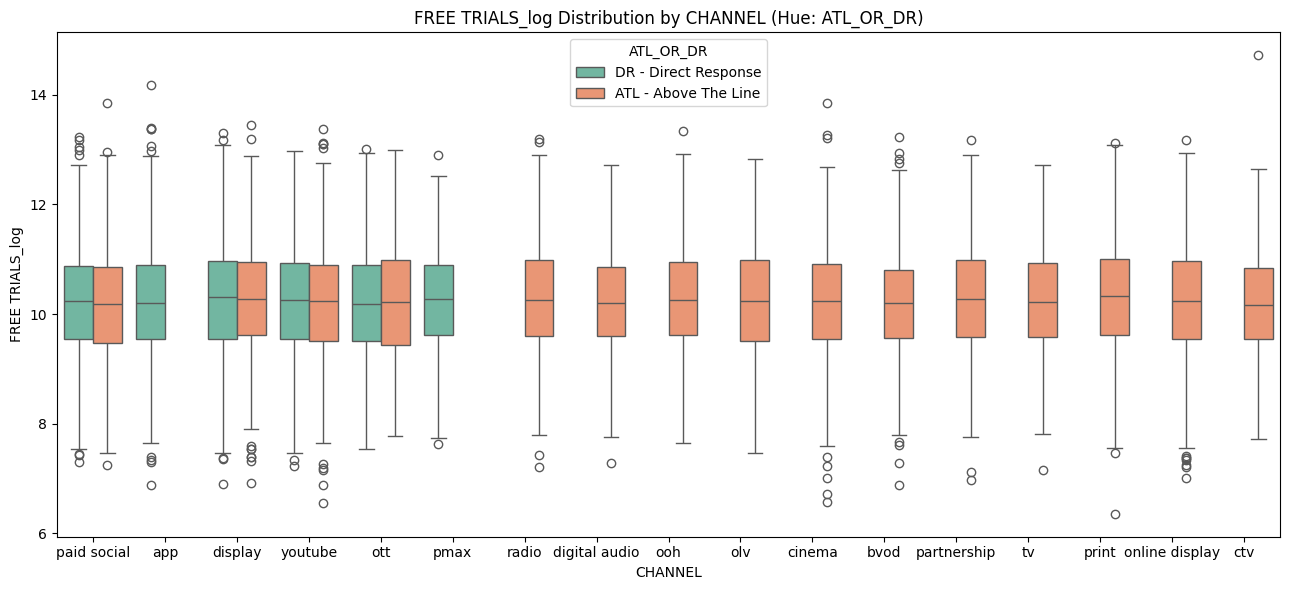

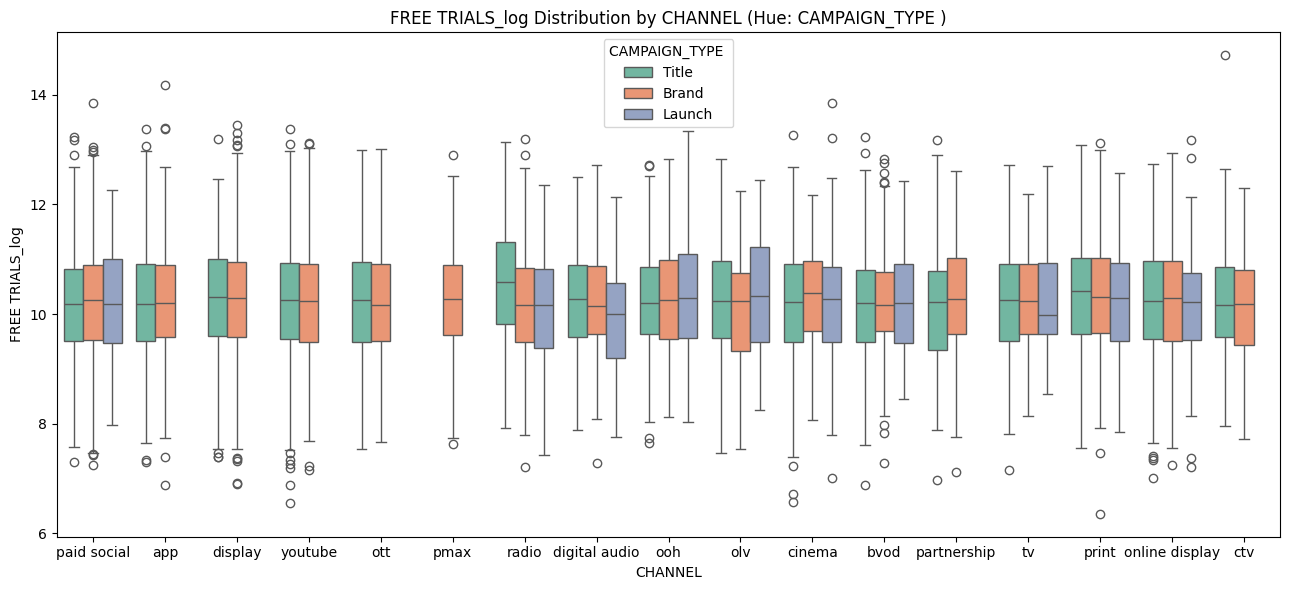

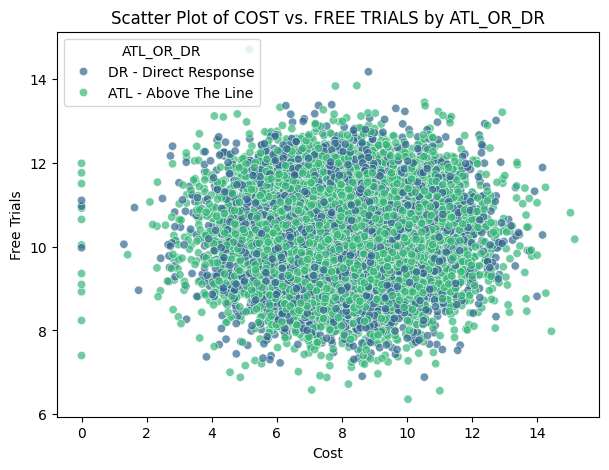

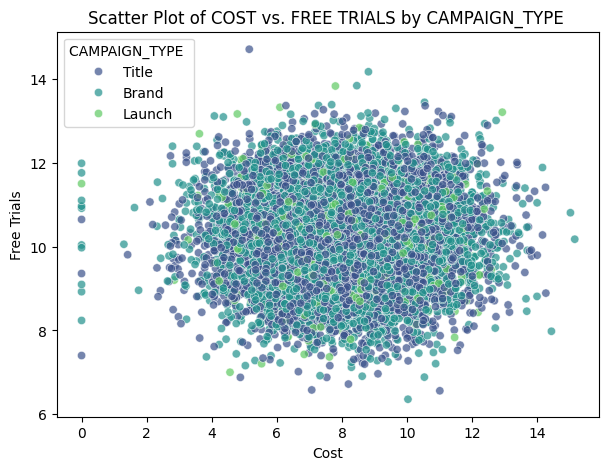

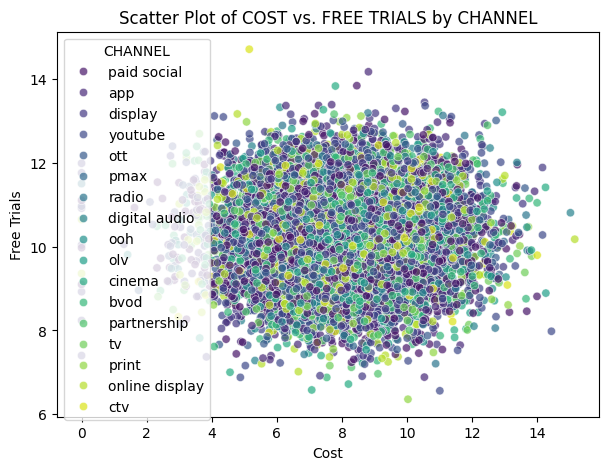

In [36]:
'''
ATL (Above The Line) vs. Cost
Both campaign strategy share similar varaince in their costs distribution.

campaign_type (Brand) vs. Cost
Both Title/Brand share similar cost behaviors. Meanwhile, Launch offers more variance
in their cost distribution. Which makes sense since maintaining a brand is more consistent
than launching a new product.

'''
log_quantitative = [f'{quant}_log' for quant in quantitative]

def create_boxplot(data, x_col, y_col, hue_col=None, title=None):
    plt.figure(figsize=(13, 6))
    sns.boxplot(data=data, x=x_col, y=y_col, hue=hue_col, palette="Set2")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

for quant_col in log_quantitative:
    for cat in categorical:
        create_boxplot(
            data=df,
            x_col=cat,
            y_col=quant_col,
            title=f'Log Distribution of {quant_col}',
        )

        other_categories = [hue for hue in categorical if hue != cat]
        for hue in other_categories:
            create_boxplot(
                data=df,
                x_col=cat,
                y_col=quant_col,
                hue_col=hue,
                title=f"{quant_col} Distribution by {cat} (Hue: {hue})",
            )
for cat in categorical:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        x='COST_log', y='FREE TRIALS_log', hue=cat, data=df, alpha=0.7, palette='viridis'
    )
    plt.title(f'Scatter Plot of COST vs. FREE TRIALS by {cat}')
    plt.xlabel('Cost')
    plt.ylabel('Free Trials')
    plt.show()
